In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LSTM, Input,SpatialDropout1D, GlobalMaxPool1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [2]:
# 5. Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv('dataset_50k.csv')
df.head()

Unnamed: 0  Label                                         detokenize
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...
1           1      0   buang pikir negatif laku gelisah milik putus asa
2           2      1  jujur aku takut mati aku orang aku sulit paham...
3           3      0              saya mes pasang sepatu jam saya harap
4           4      1  capek hati banget aku allah aku kayak mata ora...

In [3]:
df = df.dropna()
df

Unnamed: 0  Label                                         detokenize
0               0      1  aku luka diri aku jalan hidup sulit orang tua ...
1               1      0   buang pikir negatif laku gelisah milik putus asa
2               2      1  jujur aku takut mati aku orang aku sulit paham...
3               3      0              saya mes pasang sepatu jam saya harap
4               4      1  capek hati banget aku allah aku kayak mata ora...
...           ...    ...                                                ...
50518       50518      0  curi rampok liar begal rakyat senantiasa resah...
50519       50519      0                      saya bicara saya buat tertawa
50520       50520      1  sakit sakit guna sakit bahagia sakit bohong or...
50521       50521      1                              lantai lantai gelisah
50522       50522      1  aku tulis catat kemarin kata tunang aku laku b...

[50523 rows x 3 columns]

In [4]:
df['label'] = df['Label'].apply(lambda x: 0 if x == 0 else 1)
df.head()

Unnamed: 0  Label                                         detokenize  label
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...      1
1           1      0   buang pikir negatif laku gelisah milik putus asa      0
2           2      1  jujur aku takut mati aku orang aku sulit paham...      1
3           3      0              saya mes pasang sepatu jam saya harap      0
4           4      1  capek hati banget aku allah aku kayak mata ora...      1

<BarContainer object of 2 artists>

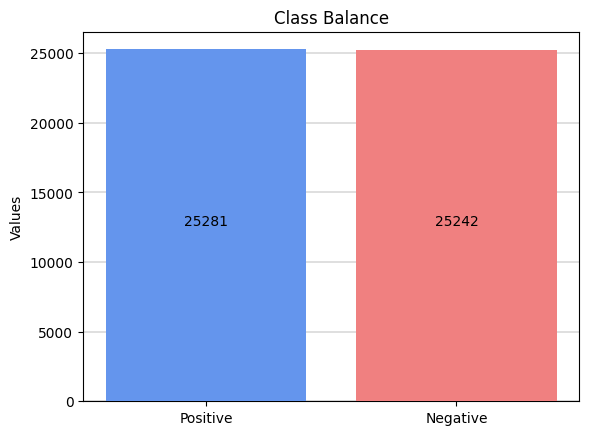

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',zorder=4)

# Count the values in the 'Label' column
count = df['Label'].value_counts()
x = ["Positive", "Negative"]  # Custom labels for class balance plot
y = [count[1], count[0]]
addlabels(x,y)
plt.ylabel("Values")
plt.title('Class Balance')
plt.grid(color='dimgray', linewidth=0.3, axis='y',zorder=0)
plt.bar(x,y, color= ['cornflowerblue', 'lightcoral'], zorder=3)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vektorisasi teks menggunakan TF-IDF unigram(1,1)
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,1), max_df=0.7, max_features=10000)

# Menggunakan fit_transform untuk mengubah dokumen menjadi fitur
vector = vectorizer.fit_transform(df['detokenize']).toarray()
tf_idf_len = len(vectorizer.vocabulary_)

In [7]:
#Split data 70% data train and 30% data test
x_unigram = pd.DataFrame(vector)
label = df["Label"]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x_unigram,label, test_size = 0.1)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(45470, 3445) (45470,)
(5053, 3445) (5053,)


In [8]:
y_train

35419    1
49199    0
5288     0
30042    1
47456    0
        ..
14999    0
16122    1
20841    1
12299    0
9594     0
Name: Label, Length: 45470, dtype: int64

In [9]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)

In [10]:
x_train

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [11]:
x_train.shape

(45470, 3445, 1)

In [12]:
import matplotlib.pyplot as plt

def make_plot(history, train, validation, title):
    graph = plt.plot(history.history[train], lw=2.0)
    graph = plt.plot(history.history[validation], lw=2.0)
    graph = plt.title(title)
    graph = plt.legend(['training', 'validasi'])
    graph = plt.show()

    return graph

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Membuat model cnn-lstm
def hybrid_cnn_lstm(x_train, y_train, x_test, y_test):


    model = Sequential()
    model.add(Input((x_train.shape[1], 1)))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=128,kernel_size=5,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(LSTM(128,return_sequences = True))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)] )

    #Membuat plot garis akurasi
    make_plot(history, "accuracy", "val_accuracy", "Perubahan Akurasi tiap epoch")

    #predict
    predictions = model.predict(x_test)
    print()
    print("Classification Report :")
    print(classification_report(y_test, predictions.round(), digits=6))


    acc_score = accuracy_score(y_test, predictions.round())
    prec_score = precision_score(y_test, predictions.round())
    rec_score = recall_score(y_test, predictions.round())
    f1score = f1_score(y_test, predictions.round())

    return [acc_score,prec_score,rec_score,f1score ]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d (SpatialDropout1D) │ (None, 3445, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1720, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,537 (27.38 MB)

 Trainable params: 7,177,537 (27.38 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 109s 72ms/step - accuracy: 0.6820 - loss: 0.5445 - val_accuracy: 0.8092 - val_loss: 0.3802
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 138s 72ms/step - accuracy: 0.7648 - loss: 0.4220 - val_accuracy: 0.8183 - val_loss: 0.3644
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 142s 73ms/step - accuracy: 0.7808 - loss: 0.3930 - val_accuracy: 0.8237 - val_loss: 0.3587
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 142s 73ms/step - accuracy: 0.7930 - loss: 0.3705 - val_accuracy: 0.8260 - val_loss: 0.3565
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 103s 72ms/step - accuracy: 0.8073 - loss: 0.3442 - val_accuracy: 0.8239 - val_loss: 0.3618
Epoch 6/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 142s 73ms/step - accuracy: 0.8115 - loss: 0.3311 - val_accuracy: 0.8243 - val_loss: 0.3826
Epoch 7/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 103s 72ms/step - accuracy: 0.8207 - loss: 0.3153 - val_accuracy: 0.8223 - val_loss: 0.3863


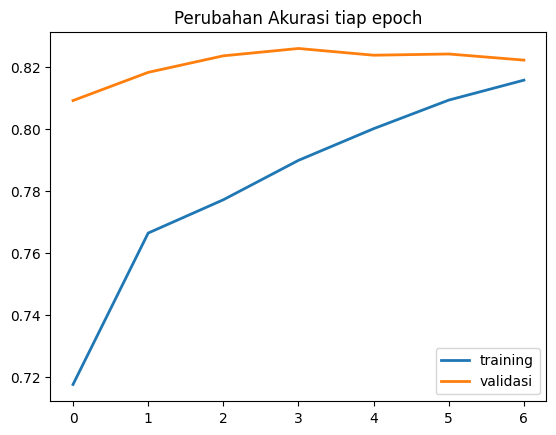

158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.842429  0.799766  0.820544      2567
           1   0.803517  0.845535  0.823991      2486

    accuracy                       0.822284      5053
   macro avg   0.822973  0.822651  0.822267      5053
weighted avg   0.823285  0.822284  0.822239      5053



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1                  │ (None, 3445, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1720, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,537 (27.38 MB)

 Trainable params: 7,177,537 (27.38 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 106s 73ms/step - accuracy: 0.6941 - loss: 0.5306 - val_accuracy: 0.7991 - val_loss: 0.3987
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 141s 73ms/step - accuracy: 0.7645 - loss: 0.4192 - val_accuracy: 0.8284 - val_loss: 0.3537
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 142s 73ms/step - accuracy: 0.7863 - loss: 0.3805 - val_accuracy: 0.8312 - val_loss: 0.3511
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 142s 73ms/step - accuracy: 0.7971 - loss: 0.3547 - val_accuracy: 0.8314 - val_loss: 0.3457
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 145s 75ms/step - accuracy: 0.8205 - loss: 0.3231 - val_accuracy: 0.8256 - val_loss: 0.3694
Epoch 6/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 139s 73ms/step - accuracy: 0.8259 - loss: 0.3088 - val_accuracy: 0.8300 - val_loss: 0.3666
Epoch 7/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 141s 73ms/step - accuracy: 0.8326 - loss: 0.2929 - val_accuracy: 0.8270 - val_loss: 0.3843


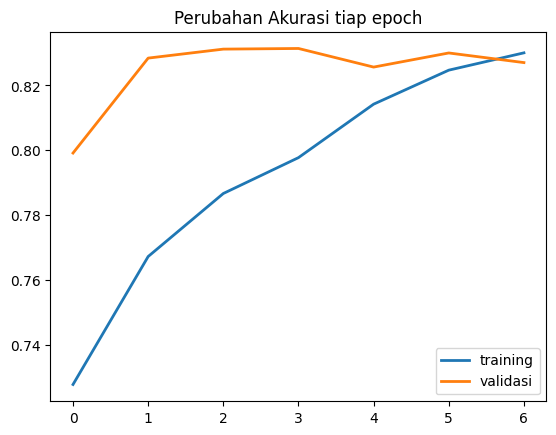

158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.839279  0.815738  0.827341      2567
           1   0.815090  0.838697  0.826725      2486

    accuracy                       0.827033      5053
   macro avg   0.827184  0.827217  0.827033      5053
weighted avg   0.827378  0.827033  0.827038      5053



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_2                  │ (None, 3445, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1720, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,537 (27.38 MB)

 Trainable params: 7,177,537 (27.38 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 106s 73ms/step - accuracy: 0.6940 - loss: 0.5302 - val_accuracy: 0.8126 - val_loss: 0.3769
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 142s 73ms/step - accuracy: 0.7669 - loss: 0.4181 - val_accuracy: 0.8227 - val_loss: 0.3631
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 142s 73ms/step - accuracy: 0.7874 - loss: 0.3813 - val_accuracy: 0.8262 - val_loss: 0.3524
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 142s 73ms/step - accuracy: 0.8021 - loss: 0.3528 - val_accuracy: 0.8243 - val_loss: 0.3596
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 142s 73ms/step - accuracy: 0.8107 - loss: 0.3284 - val_accuracy: 0.8231 - val_loss: 0.3634
Epoch 6/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 142s 73ms/step - accuracy: 0.8239 - loss: 0.3081 - val_accuracy: 0.8205 - val_loss: 0.3769


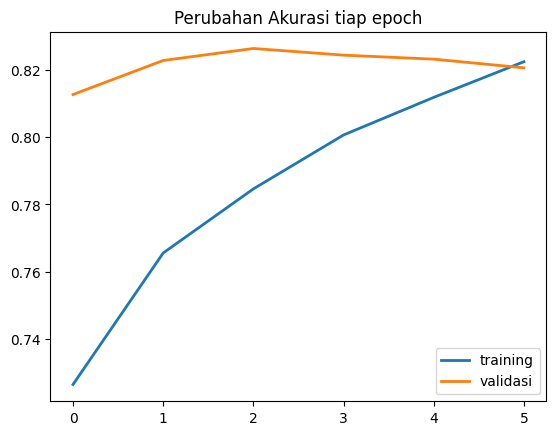

158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.844971  0.791975  0.817615      2567
           1   0.798262  0.849960  0.823300      2486

    accuracy                       0.820503      5053
   macro avg   0.821617  0.820967  0.820458      5053
weighted avg   0.821991  0.820503  0.820412      5053



In [14]:
result = []
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))

In [15]:
average = np.mean(result, axis=0, dtype=float)
print('Average Accuracy  :', average[0])
print('Average Precision :', average[1])
print('Average Recall    :', average[2])
print('Average F1-Score  :', average[3])

Average Accuracy  : 0.8232733029883237
Average Precision : 0.8056229723904181
Average Recall    : 0.8447304907481898
Average F1-Score  : 0.8246718759315158
